In [27]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(patchwork)
library(tidymodels)
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [3]:
set.seed(1) 
player_data = read_csv('https://raw.githubusercontent.com/Inesh-DSCI/Group-Project-Final/refs/heads/main/players.csv')
player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


# Data Wrangling
- Removal of NA's
- Subscriber value column and value name change
- Selection of Age, subscriber_status, experience columns
- Ranking of Experience levels and assigning numeric values to levels

In [4]:
player_data_selected<-player_data|>
 filter(!is.na(Age))|>
  mutate(subscriber_status = as_factor(subscribe)) |>
  mutate(subscriber_status= fct_recode(subscriber_status, "subscribed" = "TRUE", "Not Subscribed" = "FALSE"))|>
select(Age, subscriber_status, experience)
player_data_selected

Age,subscriber_status,experience
<dbl>,<fct>,<chr>
9,subscribed,Pro
17,subscribed,Veteran
17,Not Subscribed,Veteran
⋮,⋮,⋮
22,Not Subscribed,Veteran
57,Not Subscribed,Amateur
17,Not Subscribed,Amateur


In [5]:
player_order<-player_data_selected|>
mutate(experience= factor(experience, levels= c("Beginner","Amateur","Regular","Pro","Veteran"),ordered=TRUE))|>
mutate(experience_level=as.numeric(experience))
player_order

Age,subscriber_status,experience,experience_level
<dbl>,<fct>,<ord>,<dbl>
9,subscribed,Pro,4
17,subscribed,Veteran,5
17,Not Subscribed,Veteran,5
⋮,⋮,⋮,⋮
22,Not Subscribed,Veteran,5
57,Not Subscribed,Amateur,2
17,Not Subscribed,Amateur,2


It must be noted that in order to rank the experience levels in order,factor (), a function from forcats (a package part of tidyverse) that was not covered in class was used. Information regarding the use of factor was collected from: https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/factor 


<h2> Player Data </h2>

In [28]:
subscriber_max_min_avrg_hours = player_data |>
    group_by(subscribe) |>
    summarize(max_hours = max(played_hours, na.rm = TRUE),
             average_hours = mean(played_hours, na.rm = TRUE),
             min_hours = min(played_hours, na.rm = TRUE)) |>
    mutate(max_hours = round(max_hours, digits = 2),
          average_hours = round(average_hours, digits = 2),
          min_hours = round(min_hours, digits = 2))


number_of_subscribers = player_data |>
    group_by(experience) |>
    summarize(yes_subscribed = sum(subscribe, na.rm = TRUE),
             no_subscribed = sum(!subscribe, na.rm = TRUE))

subscriber_max_min_avrg_hours
number_of_subscribers

subscribe,max_hours,average_hours,min_hours
<lgl>,<dbl>,<dbl>,<dbl>
FALSE,7.1,0.50,0
TRUE,223.1,7.78,0


experience,yes_subscribed,no_subscribed
<chr>,<int>,<int>
Amateur,45,18
Beginner,27,8
Pro,10,4
Regular,29,7
Veteran,33,15


<h2> Visualization </h2>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


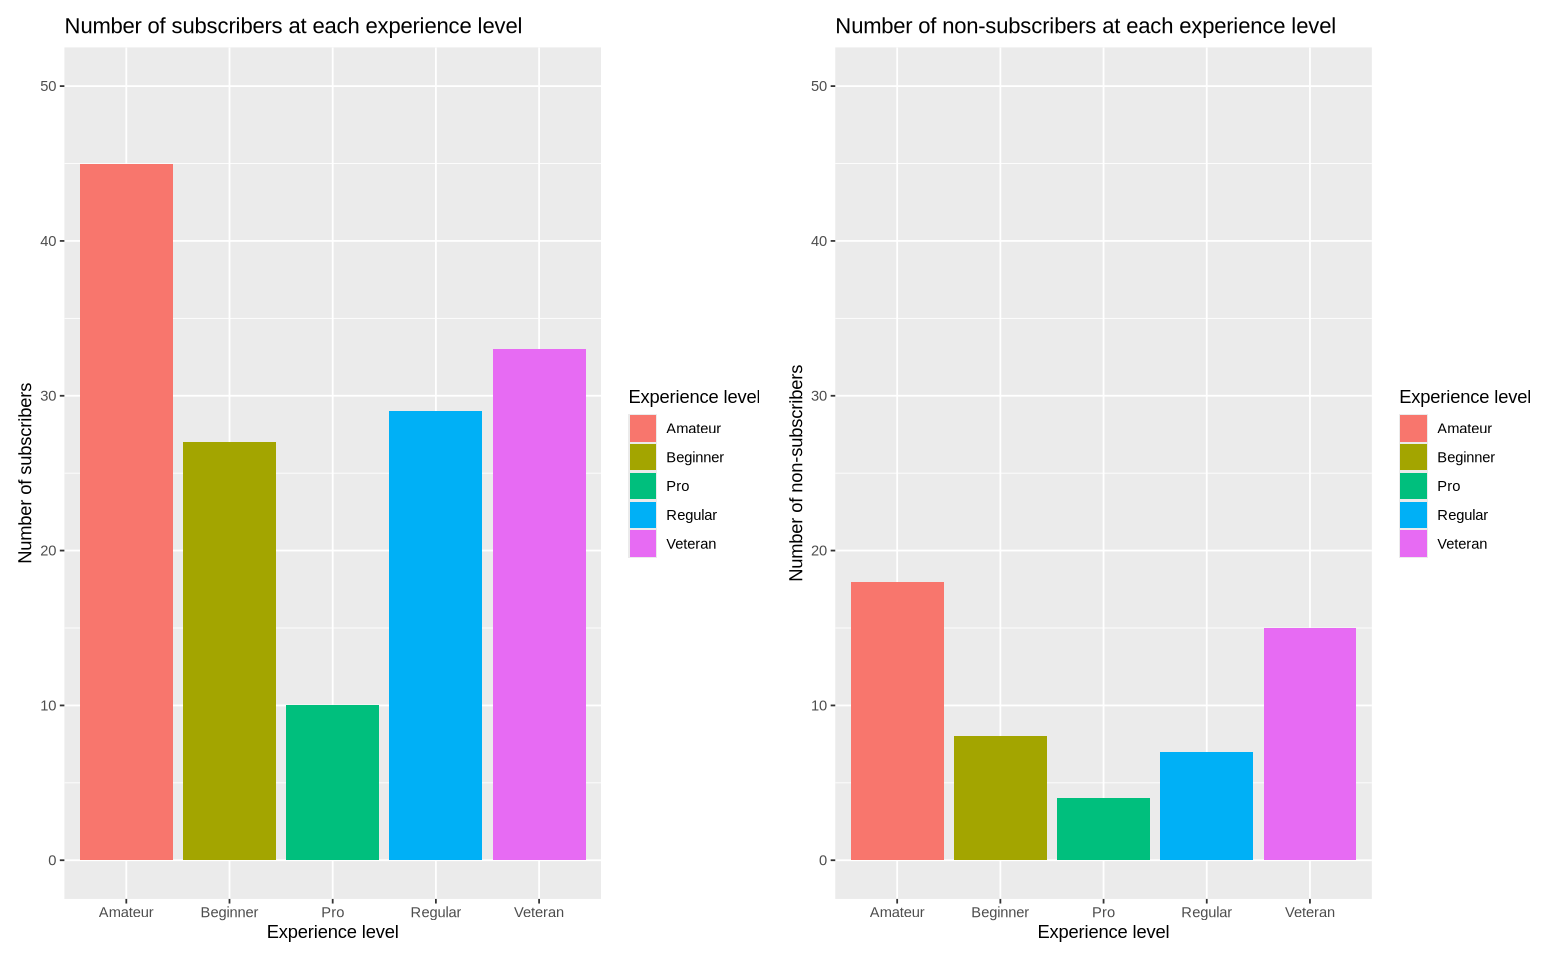

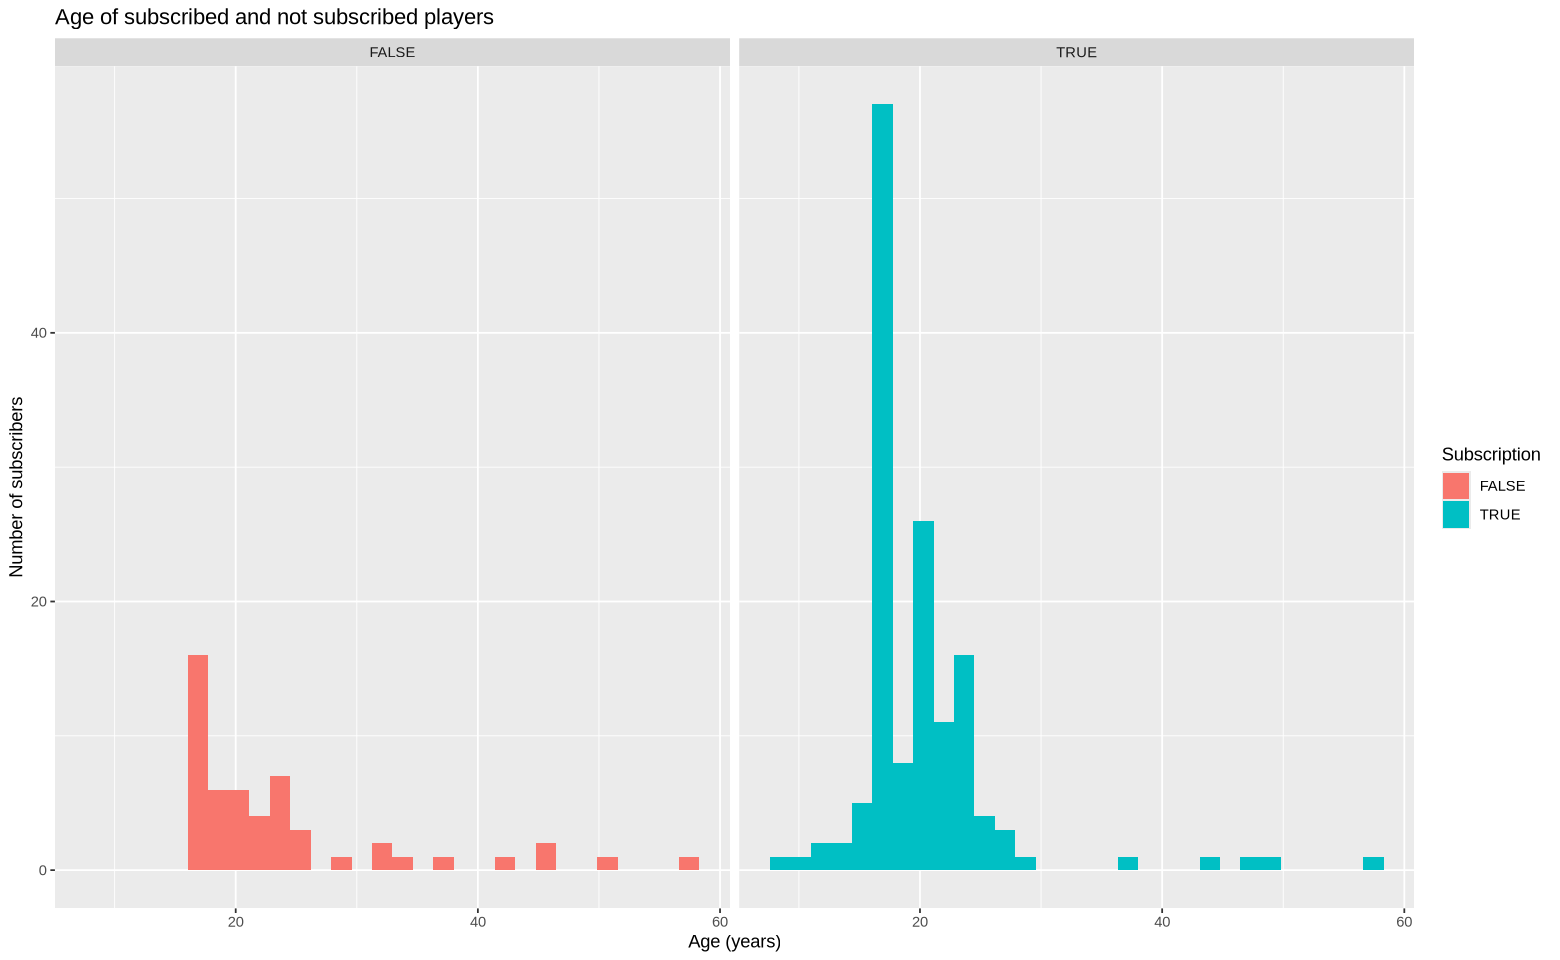

In [30]:
options(repr.plot.width = 13, repr.plot.height = 8)

subscribe_and_experience_plot1 = number_of_subscribers |>
    ggplot(aes(x = experience, y = yes_subscribed, fill = experience)) +
    geom_bar(stat = 'identity') +
    ylim(0, 50) +
    labs(x = 'Experience level', y = 'Number of subscribers', fill = 'Experience level') +
    ggtitle('Number of subscribers at each experience level')

subscribe_and_experience_plot2 = number_of_subscribers |>
    ggplot(aes(x = experience, y = no_subscribed, fill = experience)) +
    geom_bar(stat = 'identity') +
    ylim(0, 50) +
    labs(x = 'Experience level', y = 'Number of non-subscribers', fill = 'Experience level') +
    ggtitle('Number of non-subscribers at each experience level')

subscribe_and_experience_plot0 = subscribe_and_experience_plot1 + subscribe_and_experience_plot2

subscribe_vs_age = player_data |>
    ggplot(aes(x = Age, fill = subscribe)) +
    geom_histogram() +
    facet_grid(cols = vars(subscribe)) +
    labs(x = 'Age (years)', y = 'Number of subscribers', fill = 'Subscription') +
    ggtitle('Age of subscribed and not subscribed players')

subscribe_and_experience_plot0
subscribe_vs_age

# Determining K

Data Scaling

In [6]:

player_data_scaled<-player_order|>
mutate(scaled_Age = scale(Age, center = TRUE),
scaled_experience_level = scale(experience_level, center = TRUE))

Data Split

In [7]:
player_split <- initial_split(player_order, prop = 0.75, strata = subscriber_status)  
player_train <- training(player_split)
player_test <- testing(player_split)

Recipe

In [51]:
player_recipe <- recipe(subscriber_status ~ experience_level + Age, data = player_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors()) 
                
player_recipe2 <- recipe(subscriber_status ~ experience_level + Age, data = player_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors()) |>
                prep()

In [52]:
scaled_data <- bake(player_recipe2, player_data_scaled)
scaled_data

experience_level,Age,subscriber_status
<dbl>,<dbl>,<fct>
0.7046795,-1.7011593,subscribed
1.3769067,-0.5831169,subscribed
1.3769067,-0.5831169,Not Subscribed
⋮,⋮,⋮
1.3769067,0.1156596,Not Subscribed
-0.6397748,5.0070949,Not Subscribed
-0.6397748,-0.5831169,Not Subscribed


Model

In [53]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
            set_engine("kknn") |>
            set_mode("classification")

Fit

In [54]:
player_fit <- workflow() |>
             add_recipe(player_recipe) |>
             add_model(knn_spec) |>
             fit(data = player_train)
player_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4551724
Best kernel: rectangular
Best k: 3

Predicitons

In [55]:
player_test_predictions <- predict(player_fit, player_test) |>
                          bind_cols(player_test)
player_test_predictions

.pred_class,Age,subscriber_status,experience,experience_level
<fct>,<dbl>,<fct>,<ord>,<dbl>
subscribed,21,subscribed,Amateur,2
subscribed,21,subscribed,Regular,3
Not Subscribed,17,subscribed,Amateur,2
⋮,⋮,⋮,⋮,⋮
subscribed,20,subscribed,Amateur,2
subscribed,57,Not Subscribed,Amateur,2
Not Subscribed,17,Not Subscribed,Amateur,2


Prediciton Accuracy 

In [12]:
player_prediction_accuracy <- player_test_predictions |>
                        metrics(truth = subscriber_status, estimate = .pred_class)
player_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.53061224
kap,binary,-0.02734731


K results

In [13]:
player_vfold <- vfold_cv(player_train, v = 5, strata = subscriber_status)

player_resample_fit <- workflow() |>
                      add_recipe(player_recipe) |>
                      add_model(knn_spec) |>
                      fit_resamples(resamples = player_vfold)

player_metrics <- player_resample_fit |> collect_metrics()
player_metrics


.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.5626601,5,0.07253574,Preprocessor1_Model1
roc_auc,binary,0.5176291,5,0.04447531,Preprocessor1_Model1


In [14]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by =1))

knn_results <- workflow() |>
               add_recipe(player_recipe) |>
               add_model(knn_tune) |>
               tune_grid(resamples = player_vfold, grid = k_vals) |>
               collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.453711,5,0.05200619,Preprocessor1_Model01
1,roc_auc,binary,0.520671,5,0.05033941,Preprocessor1_Model01
2,accuracy,binary,0.432775,5,0.04955124,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.6052180,5,0.04277747,Preprocessor1_Model09
10,accuracy,binary,0.7587521,5,0.01836303,Preprocessor1_Model10
10,roc_auc,binary,0.6256957,5,0.05730150,Preprocessor1_Model10


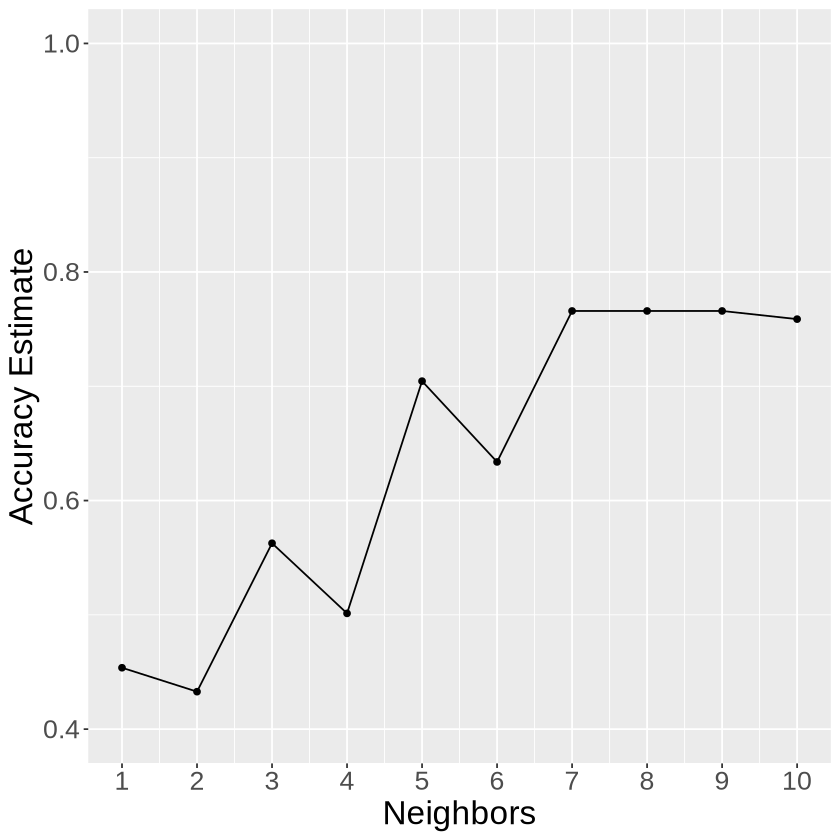

In [15]:
accuracies <- knn_results |>
              filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                     geom_point() +
                     geom_line() +
                     labs(x = "Neighbors", y = "Accuracy Estimate") +
                     theme(text = element_text(size = 20)) +
                     scale_x_continuous(breaks = seq(0, 14, by = 1)) +
                     scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k


In [16]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 7

# Data Analysis With Optimal K

Tuned Accuracy 

In [17]:
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
            set_engine("kknn") |>
            set_mode("classification")

player_fit_tuned <- workflow() |>
             add_recipe(player_recipe) |>
             add_model(knn_spec_tuned) |>
             fit(data = player_train)

player_test_predictions_tuned <- predict(player_fit_tuned, player_test) |>
                          bind_cols(player_test)
player_test_predictions_tuned

player_prediction_accuracy_tuned <- player_test_predictions_tuned |>
                        metrics(truth = subscriber_status, estimate = .pred_class)
player_prediction_accuracy_tuned


.pred_class,Age,subscriber_status,experience,experience_level
<fct>,<dbl>,<fct>,<ord>,<dbl>
subscribed,21,subscribed,Amateur,2
subscribed,21,subscribed,Regular,3
subscribed,17,subscribed,Amateur,2
⋮,⋮,⋮,⋮,⋮
subscribed,20,subscribed,Amateur,2
Not Subscribed,57,Not Subscribed,Amateur,2
subscribed,17,Not Subscribed,Amateur,2


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7551020
kap,binary,0.1671388


Vizualization

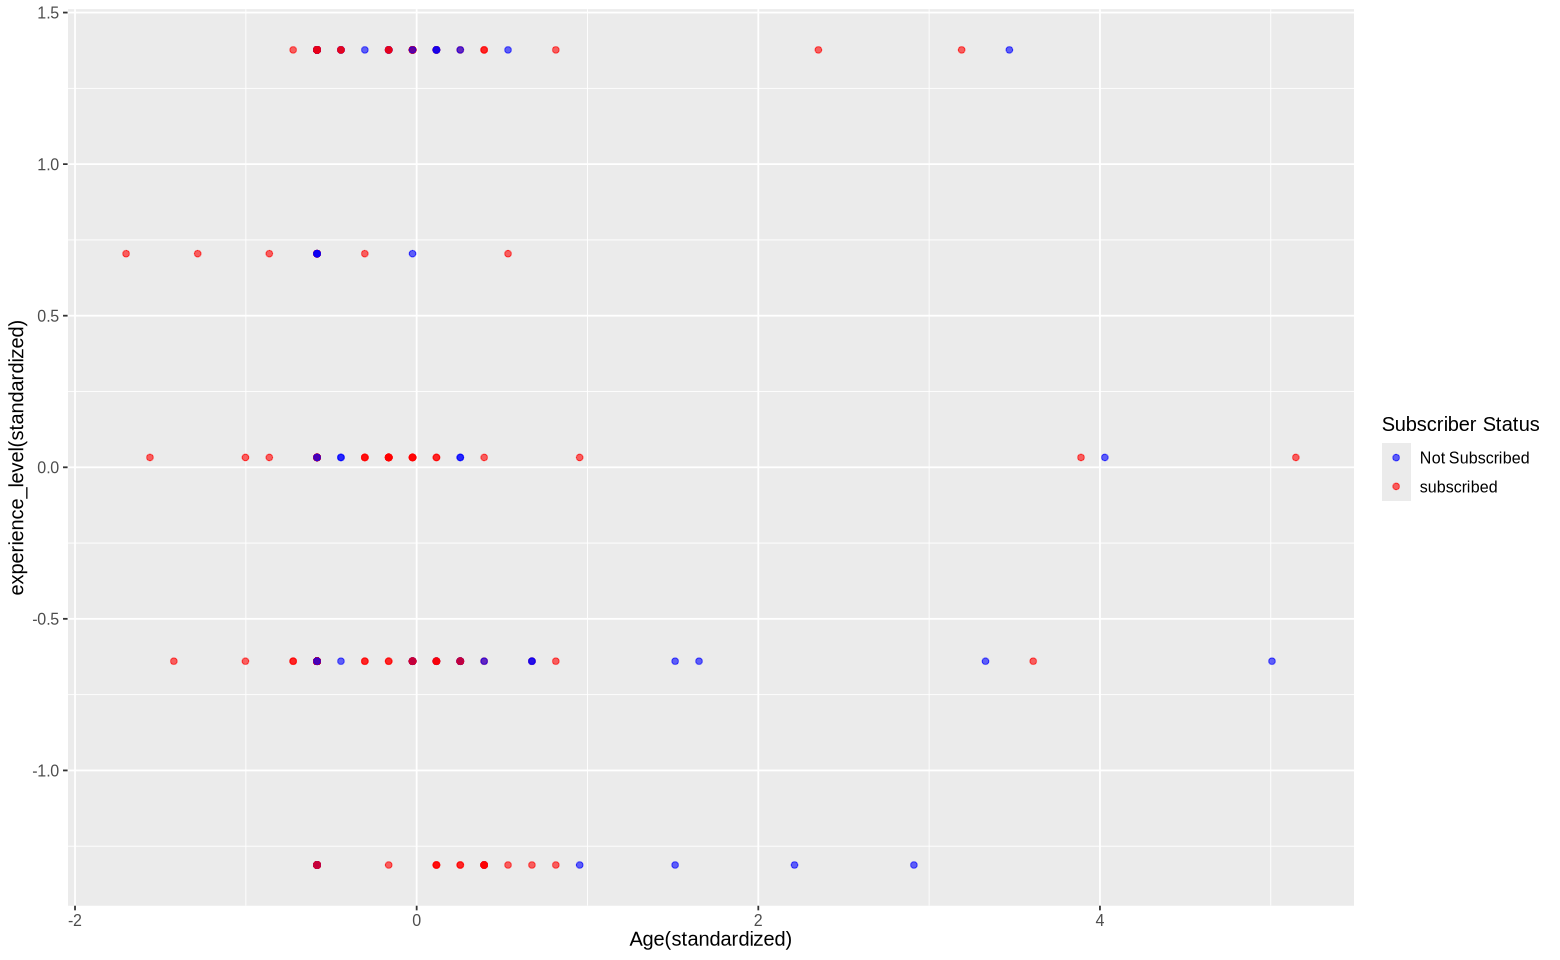

In [56]:
viz <- scaled_data |>
  ggplot(aes(x = Age, y = experience_level, color = subscriber_status)) +
  geom_point(alpha = 0.6) +
  labs(x = "Age(standardized)",
       y = "experience_level(standardized)",
       color = "Subscriber Status") +
  scale_color_manual(values = c("blue", "red")) +
  theme(text = element_text(size = 12))
viz